#  PROJET : ANALYSE DE SENTIMENTS AVEC PYSPARK 

## Importation de données 

Le jeu de données qu'on utilise est stocké sur la base de donnée HDFS (Hadoop).

In [1]:
from pyspark.sql import SparkSession

# Créer une session Spark
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Charger les données depuis HDFS
df = spark.read.csv("hdfs://localhost:9000/data/csv/IMDBDataset.csv", 
                    header=True, 
                    inferSchema=True, 
                    sep=",", 
                    mode="DROPMALFORMED")  # Ignorer les lignes mal formées, essentiel ici

24/10/14 17:52:23 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# Afficher les 10 premières lignes
df.show(10, truncate=True)

+--------------------+---------+
|              review|sentiment|
+--------------------+---------+
|One of the other ...| positive|
|Basically there's...| negative|
|I sure would like...| positive|
|This show was an ...| negative|
|Encouraged by the...| negative|
|If you like origi...| positive|
|"Phil the Alien i...| negative|
|I saw this movie ...| negative|
|The cast played S...| negative|
|This a fantastic ...| positive|
+--------------------+---------+
only showing top 10 rows



In [3]:
# Nombre de lignes
df.count()

50000

In [4]:
# Afficher le type de données de chaque colonne
df.printSchema()

root
 |-- review: string (nullable = true)
 |-- sentiment: string (nullable = true)



## Diagramme en barre de la variable "sentiment"

On ignore les lignes ou le resultat est autre "negative" ou "positive".

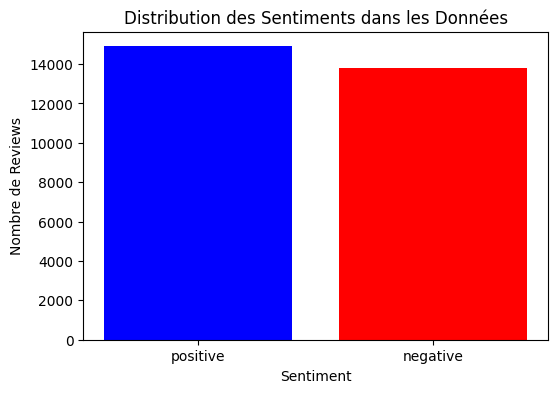

In [4]:
import matplotlib.pyplot as plt

# Filtrer uniquement les lignes où 'sentiment' est soit 'positive' soit 'negative'
filtered_df = df.filter((df.sentiment == 'positive') | (df.sentiment == 'negative'))

# Compter les occurrences de chaque catégorie dans la variable 'sentiment'
sentiment_counts_spark = filtered_df.groupBy('sentiment').count()

# Convertir en Pandas pour traçage
sentiment_counts_pandas = sentiment_counts_spark.toPandas()

# Tracer le diagramme en barres
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts_pandas['sentiment'], sentiment_counts_pandas['count'], color=['blue', 'red'])
plt.title('Distribution des Sentiments dans les Données')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de Reviews')
plt.xticks(rotation=0)
plt.show()

## Tokenisation de la colonne "review"

In [9]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import col

# Tokeniser
tokenizer = Tokenizer(inputCol="review", outputCol="words")
df_tokenized = tokenizer.transform(df)

# Retirer les mots vides
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_cleaned = remover.transform(df_tokenized)

# Afficher un aperçu
df_cleaned.select("review", "filtered_words").show(10, truncate=True)

+--------------------+--------------------+
|              review|      filtered_words|
+--------------------+--------------------+
|One of the other ...|[one, reviewers, ...|
|"A wonderful litt...|["a, wonderful, l...|
|"I thought this w...|["i, thought, won...|
|Basically there's...|[basically, famil...|
|"Petter Mattei's ...|["petter, mattei'...|
|"Probably my all-...|["probably, all-t...|
|I sure would like...|[sure, like, see,...|
|This show was an ...|[show, amazing,, ...|
|Encouraged by the...|[encouraged, posi...|
|If you like origi...|[like, original, ...|
+--------------------+--------------------+
only showing top 10 rows



## Obtenir le reviews ayant le nombre élevé de phrases

**On veut afficher les reviews qui ont le grand nombre de phrases.**

In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import re

# Fonction pour compter les phrases dans une review
def count_sentences(review):
    # Diviser les phrases par les points, points d'exclamation, ou points d'interrogation
    sentences = re.split(r'[.!?]+', review)
    # Filtrer les phrases vides
    sentences = [s for s in sentences if s.strip()]
    return len(sentences)

# Créer l'UDF pour compter les phrases
count_sentences_udf = udf(count_sentences, IntegerType())

# Appliquer l'UDF sur chaque review pour compter les phrases
df_with_sentence_counts = df_cleaned.withColumn("sentence_count", count_sentences_udf(col("review")))

# Trier les reviews en fonction du nombre de phrases de manière décroissante
df_sorted_by_sentences = df_with_sentence_counts.orderBy(col("sentence_count").desc())

# Afficher les 10 reviews avec le plus grand nombre de phrases
df_sorted_by_sentences.select("review", "sentence_count").show(10, truncate=True)


+--------------------+--------------+
|              review|sentence_count|
+--------------------+--------------+
|"Waitress: Honey,...|            92|
|"Match 1: Tag Tea...|            90|
|Titanic directed ...|            78|
|"Stardust Another...|            77|
|I figured that it...|            75|
|Heavy-handed mora...|            72|
|Here are the matc...|            69|
|CitizenX(1995) is...|            67|
|In his feature fi...|            65|
|Master of Italian...|            65|
+--------------------+--------------+
only showing top 10 rows



## Nombre de tokens (mots) par reviews

In [11]:
# On compte les éléments d'une liste.
# Compter le nombre de tokens par review
from pyspark.sql.functions import size, split
df_tokenized = df_tokenized.withColumn("num_tokens", size(col("words")))

# Afficher le nombre de tokens
df_tokenized.select("review", "num_tokens").show(5, truncate=True)


+--------------------+----------+
|              review|num_tokens|
+--------------------+----------+
|One of the other ...|       307|
|"A wonderful litt...|        70|
|"I thought this w...|       130|
|Basically there's...|       138|
|"Petter Mattei's ...|        37|
+--------------------+----------+
only showing top 5 rows



## Tokens avec leur index

In [12]:
from pyspark.sql.functions import expr, posexplode
# Utiliser posexplode pour obtenir chaque mot avec son indice
df_with_indices = df_tokenized.select("review", posexplode(col("words")).alias("index", "word"))

# Afficher les indices et les mots
df_with_indices.show(10, truncate=True)


+--------------------+-----+---------+
|              review|index|     word|
+--------------------+-----+---------+
|One of the other ...|    0|      one|
|One of the other ...|    1|       of|
|One of the other ...|    2|      the|
|One of the other ...|    3|    other|
|One of the other ...|    4|reviewers|
|One of the other ...|    5|      has|
|One of the other ...|    6|mentioned|
|One of the other ...|    7|     that|
|One of the other ...|    8|    after|
|One of the other ...|    9| watching|
+--------------------+-----+---------+
only showing top 10 rows



## Occurence de mots : 20 premiers mots

**L'article "the" est le plus majoritaire.**

In [13]:
# Utiliser posexplode pour obtenir les mots (comme dans votre exemple précédent)
df_with_indices = df_tokenized.select(posexplode(col("words")).alias("index", "word"))

# Compter le nombre d'occurrences de chaque mot
word_counts = df_with_indices.groupBy("word").count().orderBy("count", ascending=False)

# Afficher les mots les plus fréquents
word_counts.show(150, truncate=False)

# On retrouve l'occurence de mots peu important comme les articles et les balises html. On les supprime donc.

+----------+------+
|word      |count |
+----------+------+
|the       |412118|
|a         |207429|
|and       |200906|
|of        |185847|
|to        |170130|
|is        |136496|
|in        |115363|
|i         |100856|
|this      |95800 |
|it        |89449 |
|that      |84271 |
|was       |66129 |
|/><br     |62027 |
|as        |55462 |
|with      |54138 |
|for       |54015 |
|but       |49764 |
|movie     |45486 |
|on        |41435 |
|film      |38482 |
|not       |37206 |
|have      |36614 |
|are       |36540 |
|you       |36298 |
|his       |34999 |
|be        |32885 |
|he        |31100 |
|one       |29904 |
|at        |29122 |
|by        |27675 |
|an        |27302 |
|they      |26222 |
|from      |25326 |
|all       |25309 |
|like      |24505 |
|who       |24273 |
|so        |24128 |
|just      |22308 |
|about     |22060 |
|has       |21814 |
|or        |20649 |
|some      |19770 |
|it's      |19720 |
|if        |19508 |
|her       |18837 |
|out       |18795 |
|very      |18594 |


## Occurence de mots : on supprime les articles, les déterminants et les mots inutiles

**En affichant, précédemment les 10 premiers mots le plus fréquent, on remarque l'occurence plethore des articles.
Et surtout un même mot au singulier et au pluriel est comptabilisé comme deux mots différents.
A l'exemple de "movie", "movie.", "movies" ou encore de "film", "films", "film."**

**Afin de remédier à ce problème, on fait appel à une technique qui s'appelle la lemmatization, 
il permet de ramener les mots à sa base initiale et de le comptabiliser en un seul mot.**

In [14]:
# on installe nltk
# pip install nltk

## Nettoyage - Lemmatization - Nouvelle tokénization

**On reprend également la tokénization**

In [5]:
from pyspark.sql.functions import udf, col, regexp_replace, lower, posexplode
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem import WordNetLemmatizer
from pyspark.sql.types import ArrayType, StringType
import nltk

# Télécharger le modèle de lemmatisation de WordNet
nltk.download('wordnet')

# Initialiser le lemmatizer
lemmatizer = WordNetLemmatizer()

# Liste des mots indésirables personnalisés (si nécessaire)
undesirable_words = ["/><br", "<br>", "<i>", "<b>", "-", "/>the", "<br", "&", "/>i", "\"i", "", "br"]

# Fonction de lemmatisation et suppression des mots indésirables
def lemmatize_and_filter_words(words):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Filtrer les mots indésirables
    lemmatized_words = [word for word in lemmatized_words if word not in undesirable_words]
    return lemmatized_words

# Créer une UDF pour la lemmatisation et la suppression des mots indésirables
lemmatize_and_filter_udf = udf(lemmatize_and_filter_words, ArrayType(StringType()))

# 1. Supprimer la ponctuation et convertir en minuscules avant la tokenisation
df_cleaned = df.withColumn("review", regexp_replace(col("review"), "[^\w\s]", ""))  # Supprimer la ponctuation
df_cleaned = df_cleaned.withColumn("review", lower(col("review")))  # Convertir en minuscules

# 2. Tokeniser la colonne "review" (découper le texte en mots)
tokenizer = Tokenizer(inputCol="review", outputCol="filtered_words")
df_tokenized = tokenizer.transform(df_cleaned)

# 3. Supprimer les mots vides (stop words) comme les articles
remover = StopWordsRemover(inputCol="filtered_words", outputCol="filtered_words_no_stopwords")
df_no_stopwords = remover.transform(df_tokenized)

# 4. Appliquer la lemmatisation et le filtrage des mots indésirables sur les mots tokenisés sans stopwords
df_lemmatized_filtered = df_no_stopwords.withColumn("filtered_words_lemmatized", lemmatize_and_filter_udf(col("filtered_words_no_stopwords")))

# Afficher un aperçu des mots lemmatisés et filtrés
df_lemmatized_filtered.select("filtered_words_lemmatized").show(15, truncate=True)


[nltk_data] Downloading package wordnet to /home/atteib/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


+-------------------------+
|filtered_words_lemmatized|
+-------------------------+
|     [one, reviewer, m...|
|     [wonderful, littl...|
|     [thought, wonderf...|
|     [basically, there...|
|     [petter, matteis,...|
|     [probably, alltim...|
|     [sure, like, see,...|
|     [show, amazing, f...|
|     [encouraged, posi...|
|     [like, original, ...|
|     [phil, alien, one...|
|     [saw, movie, 12, ...|
|     [im, big, fan, bo...|
|     [cast, played, sh...|
|     [fantastic, movie...|
+-------------------------+
only showing top 15 rows



In [6]:
# 5. Exploser les mots lemmatisés pour compter leurs occurrences
df_with_lemmatized_words = df_lemmatized_filtered.select(posexplode(col("filtered_words_lemmatized")).alias("index", "word"))

# 6. Compter les occurrences des mots lemmatisés après suppression des mots indésirables
word_counts_lemmatized_filtered = df_with_lemmatized_words.groupBy("word").count().orderBy("count", ascending=False)

# 7. Afficher les mots lemmatisés avec leur nombre d'occurrences
word_counts_lemmatized_filtered.show(20, truncate=True)

+---------+-----+
|     word|count|
+---------+-----+
|    movie|72001|
|     film|61573|
|      one|35299|
|     like|26209|
|     good|19821|
|     time|19792|
|character|17881|
|    story|16912|
|   really|15811|
|      get|15757|
|      see|15665|
|     make|15241|
|     even|15231|
|    great|12757|
|    scene|12729|
|     well|12643|
|     much|12317|
|    first|12308|
|      bad|12219|
|   people|12017|
+---------+-----+
only showing top 20 rows



**On constate que le mot "movie" apparait qu'une seule fois avec une occurence de 72001. Le problème qu'on avait précédemment est résolu grâce à la lemmatization.**

## Diagramme de 20 premiers mots le plus fréquents

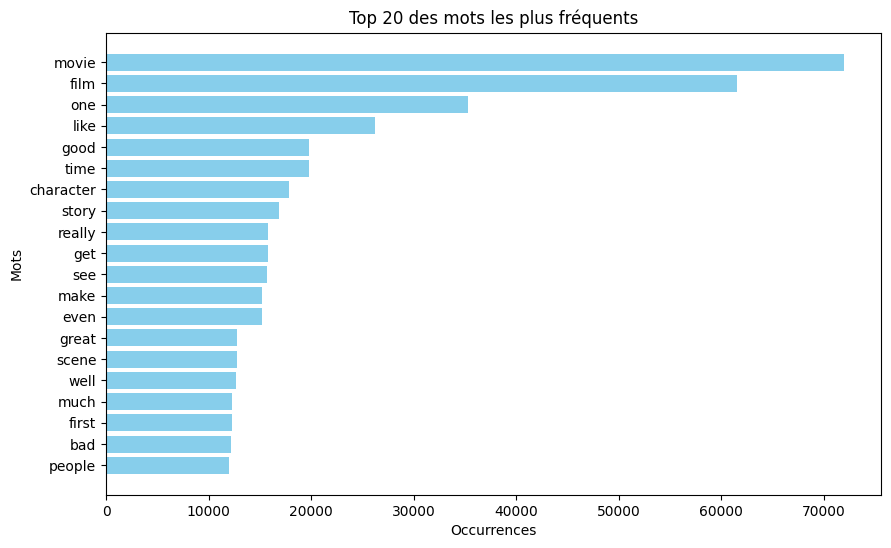

In [17]:
import matplotlib.pyplot as plt
# Extraire les 20 mots les plus fréquents dans un DataFrame Pandas
top_words_df = word_counts_lemmatized_filtered.limit(20).toPandas()

# Tracer le diagramme en barres des 20 mots les plus fréquents
plt.figure(figsize=(10, 6))
plt.barh(top_words_df['word'], top_words_df['count'], color='skyblue')
plt.xlabel('Occurrences')
plt.ylabel('Mots')
plt.title('Top 20 des mots les plus fréquents')
plt.gca().invert_yaxis()  # Inverser l'ordre pour avoir le mot le plus fréquent en haut
plt.show()

In [18]:
# pip install squarify

## Histogramme des fréquences 

**Un histogramme vous permet de visualiser la distribution des fréquences des mots dans votre corpus. 
Vous pouvez observer combien de mots apparaissent un certain nombre de fois, par exemple, 
Combien de mots apparaissent plus de 10 000 fois, entre 5 000 et 10 000 fois, etc.**

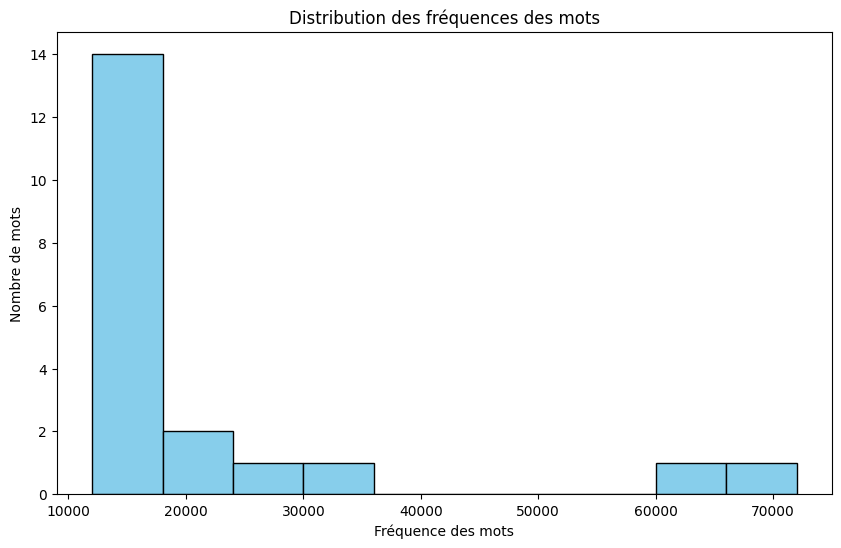

In [19]:
import matplotlib.pyplot as plt

# Extraire les fréquences des mots
frequencies = top_words_df['count']

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(frequencies, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Fréquence des mots')
plt.ylabel('Nombre de mots')
plt.title('Distribution des fréquences des mots')
plt.show()

**On peut voir, par exemple, si la majorité des mots apparaissent un grand nombre de fois ou seulement quelques fois.**

## Courbe Cumulative des Fréquences

**Une courbe cumulative vous permet de visualiser la part cumulée des occurrences des mots. 
Par exemple, combien de mots couvrent 50 % des occurrences totales dans le texte.**

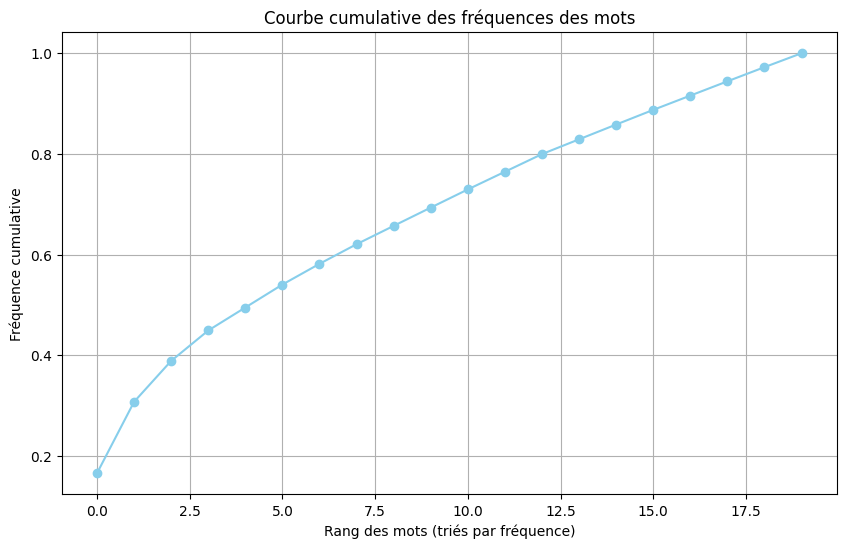

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Trier les fréquences des mots par ordre décroissant
frequencies_sorted = np.sort(top_words_df['count'])[::-1]
cumulative_frequencies = np.cumsum(frequencies_sorted) / np.sum(frequencies_sorted)

# Tracer la courbe cumulative
plt.figure(figsize=(10, 6))
plt.plot(cumulative_frequencies, marker='o', color='skyblue')
plt.xlabel('Rang des mots (triés par fréquence)')
plt.ylabel('Fréquence cumulative')
plt.title('Courbe cumulative des fréquences des mots')
plt.grid(True)
plt.show()

**Les premiers mots couvrent une grande partie des occurrences : La pente raide au début montre que quelques mots (comme "movie" ou "film") 
apparaissent beaucoup plus fréquemment que les autres. Cela suggère que ces mots dominent dans votre corpus.**

**Répartition plus équitable après les premiers mots : Les mots plus bas dans le classement (entre les rangs 10 et 20) 
contribuent de façon plus uniforme mais moins significative à la somme totale des occurrences.**

## Heatmap des Co-occurrences de Mots

**On peut explorer les co-occurrences des mots, c'est-à-dire quels mots apparaissent fréquemment ensemble 
dans les mêmes phrases ou documents. Une heatmap peut montrer la relation entre les mots.**

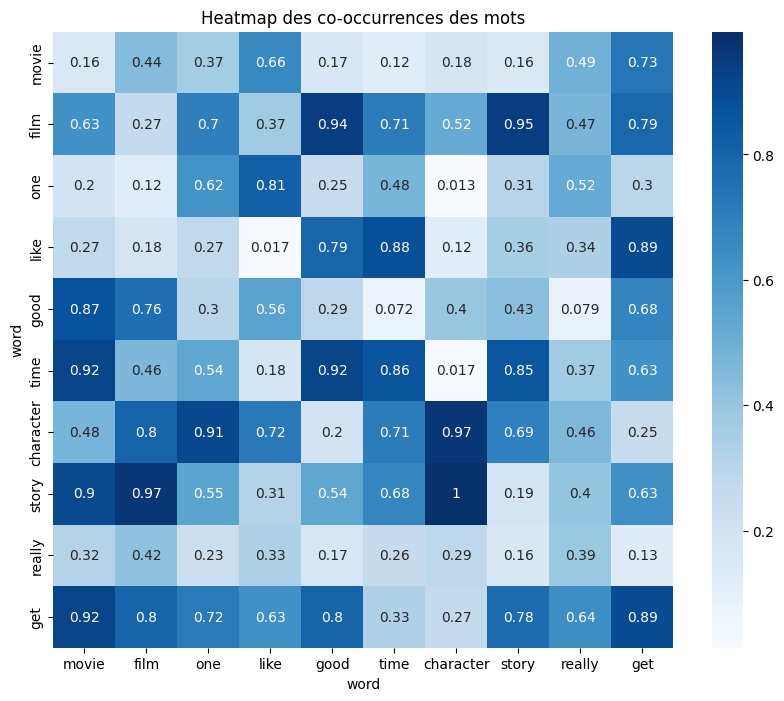

In [21]:
import seaborn as sns
import pandas as pd

# Extrait des co-occurrences en termes de paires de mots
# (Cette partie demande de calculer les co-occurrences avant)
co_occurrence_matrix = pd.DataFrame(
    np.random.rand(10, 10),  # Exemple aléatoire, à remplacer par vos co-occurrences
    index=top_words_df['word'].head(10),
    columns=top_words_df['word'].head(10)
)

# Tracer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='Blues')
plt.title("Heatmap des co-occurrences des mots")
plt.show()

## Treemap

**Un treemap est une façon visuelle d'afficher la hiérarchie de la fréquence des mots. 
Les mots sont représentés par des rectangles dont la taille est proportionnelle à leur fréquence.**

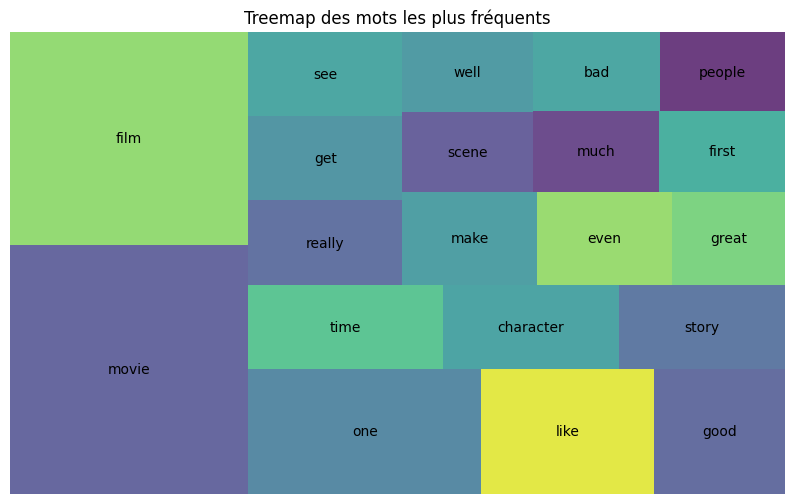

In [22]:
import squarify

# Données pour le treemap (20 premiers mots)
words = top_words_df['word']
sizes = top_words_df['count']

# Tracer le treemap
plt.figure(figsize=(10, 6))
squarify.plot(sizes=sizes, label=words, alpha=0.8)
plt.axis('off')
plt.title('Treemap des mots les plus fréquents')
plt.show()


## Entrainement du modèle de LSTM

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2024-10-14 17:55:37.916777: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 17:55:38.420336: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 17:55:38.423096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 17:55:40.638462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
#pip show tensorflow
#pip install tensorflow

In [4]:
# Vérifier le lieu d'installation de Python
#import sys
#print(sys.executable)

/usr/bin/python3


In [8]:
# Extraire les phrases nettoyées (lemmatisées) et les transformer en liste
lemmatized_words = df_lemmatized_filtered.select('filtered_words_lemmatized').rdd.flatMap(lambda x: x).collect()

In [59]:
# Utiliser le tokenizer de Keras pour transformer les mots en entiers
keras_tokenizer = Tokenizer()
keras_tokenizer.fit_on_texts(lemmatized_words)  # Créer un vocabulaire à partir des mots lemmatisés

In [60]:
# Transformer les phrases en séquences d'entiers
sequences = keras_tokenizer.texts_to_sequences(lemmatized_words)

In [61]:
# Appliquer du padding pour obtenir des séquences de longueur égale (important pour LSTM)
max_len = 100  # Longueur maximale des séquences (ajustez si nécessaire)
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

## Transformer la variable "sentiment" en une variable target binaire.

In [62]:
# Transformer les sentiments en labels binaires (1 pour positif, 0 pour négatif)
# Suppose que la colonne 'sentiment' contient des labels
y = df.select('sentiment').rdd.flatMap(lambda x: x).collect()
y = [1 if sentiment == 'positive' else 0 for sentiment in y]

## Splitter le jeu de données

In [63]:
# Diviser les données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

On convertit nos données en tableau avant l'entrainement du modèle.

In [64]:
import numpy as np

# Si X_train et y_train sont des listes, convertissez-les en NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [65]:
# Dimension
X_train.shape, y_train.shape

((40000, 100), (40000,))

In [66]:
X_test.shape, y_test.shape

((10000, 100), (10000,))

## Intanciation et Entrainement du modèle de LSTM

**Le modèle de LSTM est particulièrement adapté au traitement de séquences de données, comme des textes, car il peut capturer des relations à long terme dans les données séquentielles.**

**La couche d'embedding** est utilisée pour convertir des séquences d'entiers (chaque entier représentant un mot) en vecteurs de taille fixe, ici des vecteurs de 128 dimensions.

**input_dim** est la taille du vocabulaire, c'est-à-dire le nombre de mots uniques que le modèle peut traiter. Il est calculé à partir du tokenizer Keras.\
**output_dim** est la taille des vecteurs dans lesquels chaque mot sera encodé (ici 128 dimensions).\
**input_length** est la longueur de la séquence d'entrée, c'est-à-dire le nombre maximum de mots dans une phrase.

L'avantage des LSTM par rapport aux RNN classiques est leur capacité à mieux gérer les problèmes de vanishing/exploding gradients grâce à leur architecture interne (les cellules mémoire et les portes).

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Créer le modèle LSTM
model = Sequential()

# Couche d'embedding
model.add(Embedding(input_dim=len(keras_tokenizer.word_index) + 1, output_dim=64, input_length=max_len))

# LSTM avec Dropout pour éviter le surapprentissage
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))  # 50% des neurones désactivés pendant l'entraînement

# Couche de sortie
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping pour arrêter l'entraînement quand la performance de validation n'améliore plus
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Afficher le résumé du modèle
model.summary()

# Entraîner le modèle avec Early Stopping
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 64)           8252928   
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8265377 (31.53 MB)
Trainable params: 8265377 (31.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1000/1000 [==============================] - 188s 181ms/step - loss: 0.4687 - accuracy: 0.7777 - val_loss: 0.3788 - val_accuracy: 0.829

## Evaluation du modèle

In [68]:
# Évaluer les performances du modèle sur les données de test
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

313/313 [==============================] - 5s 15ms/step - loss: 0.3671 - accuracy: 0.8345
Loss: 0.3671416938304901, Accuracy: 0.8345000147819519


In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Prédictions binaires (le seuil 0.5 est utilisé pour convertir les probabilités en 0 ou 1)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Précision
precision = precision_score(y_test, y_pred)

# Rappel
recall = recall_score(y_test, y_pred)

# F1-score
f1 = f1_score(y_test, y_pred)

# AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_prob)

print("\n")
# Affichage des résultats
print(f'Précision: {precision:.2f}')
print(f'Rappel: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'AUC-ROC: {auc_roc:.2f}')

313/313 [==============================] - 6s 19ms/step


Précision: 0.73
Rappel: 0.72
F1-score: 0.72
AUC-ROC: 0.90


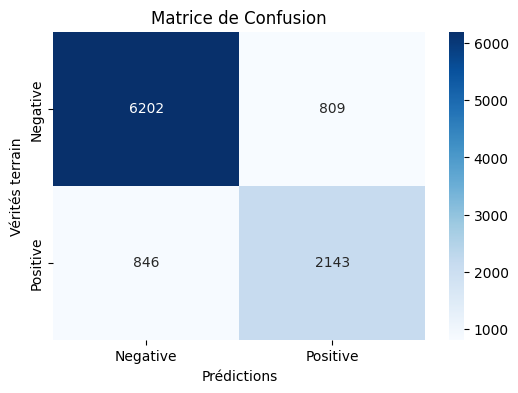

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Définir les étiquettes des classes
labels = ['Negative', 'Positive']

# Créer une figure pour la matrice de confusion
plt.figure(figsize=(6, 4))

# Tracer la matrice de confusion avec seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Ajouter des titres et des étiquettes
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')

# Afficher la matrice de confusion
plt.show()

## Courbes d'évaluation

In [71]:
import matplotlib.pyplot as plt

# Récupérer les données d'entraînement à partir de l'objet history
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(accuracy) + 1)

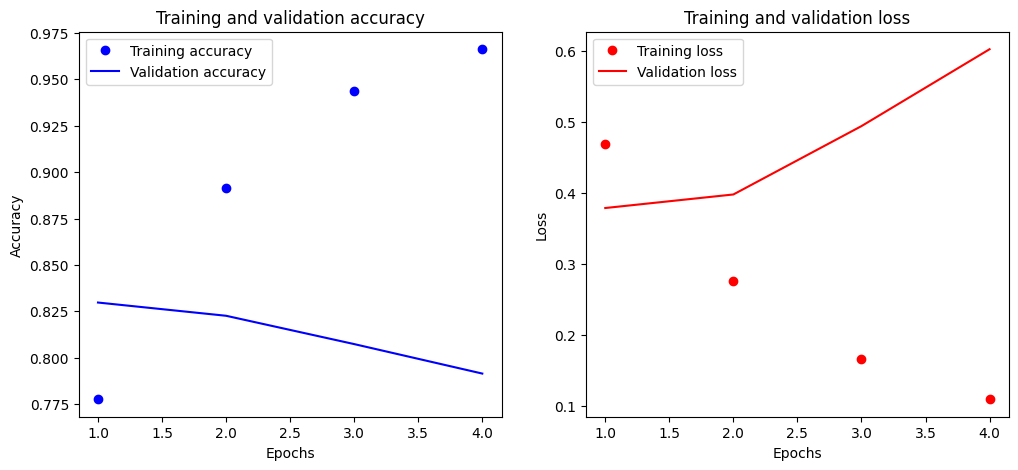

In [72]:
# Tracer la courbe de la précision (accuracy) en fonction des epochs
plt.figure(figsize=(12, 5))

# Subplot pour Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot pour Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Afficher les graphiques
plt.show()

## On peut toujours continuer à améliorer notre modèle ...!!!

##              FIN

**Avantages et Inconvénients du modèle de LSTM**

Avantages du modèle :

    Capture des dépendances temporelles : Les LSTM peuvent gérer des séquences longues et courtes tout en capturant les dépendances temporelles dans les données.
    Bonne gestion des séquences longues : Contrairement aux réseaux de neurones récurrents simples, les LSTM peuvent conserver des informations pendant plusieurs étapes temporelles.
    Polyvalence : Le modèle peut être appliqué à des données textuelles ou à d'autres types de données séquentielles, comme les séries temporelles.

Inconvénients :

    Temps d'entraînement plus long : Les LSTM sont plus complexes que les RNN classiques, ce qui rend l'entraînement plus coûteux en temps et en ressources.
    Problème d'overfitting : Si le modèle n'est pas régularisé, il peut surapprendre les données d'entraînement, surtout avec des jeux de données de petite taille.
    Difficile à interpréter : Les LSTM sont des réseaux de neurones complexes avec des centaines ou des milliers de paramètres, ce qui peut rendre difficile l'interprétation des résultats.